# Data extraction from an image of Hubble Deep Field telecope

In [110]:
import random as rdm

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

import pandas as pd
import numpy as np
import requests
import cv2

## Download image

## Convert to numpy array and decode as image

In [111]:
#image = np.asarray(bytearray(img_data), dtype="uint8")
#image = cv2.imdecode(image, cv2.IMREAD_COLOR)

image = cv2.imread('Hubble_ultra_deep_field_high_rez_edit1.jpg', cv2.IMREAD_COLOR)

print("Shape:", image.shape)
print('Array size: {:.2f} MB'.format(image.nbytes / 1000000))

Shape: (6200, 6200, 3)
Array size: 115.32 MB


## Function to get the real image size for matplotlib

In [112]:
def get_image_size(img):
    dpi = 80
    return (img.shape[0] / dpi, img.shape[1] / dpi) 

A view of the original image


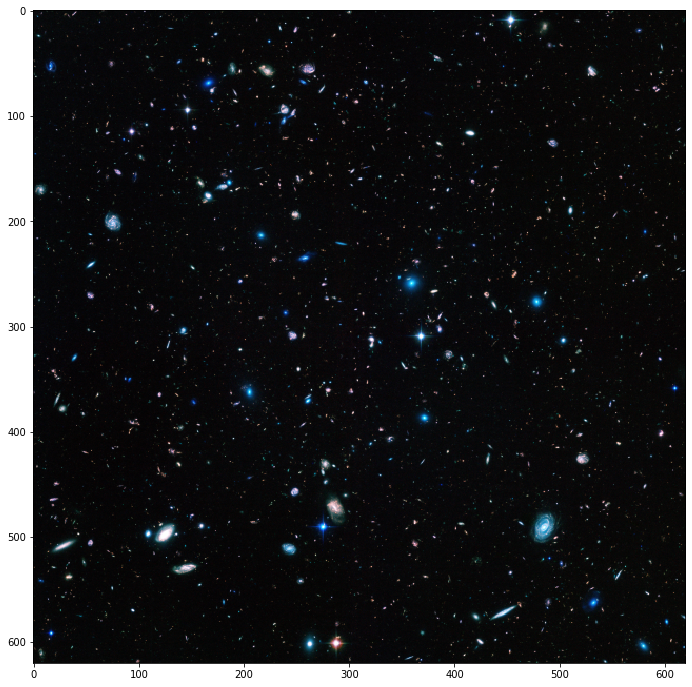

(620, 620, 3)


In [113]:
rp = 10 # Resize percent

plt.figure(figsize = (12, 12))
dim = (int(image.shape[1] *  rp * 0.01), int(image.shape[0] * rp * 0.01))

img_scaled = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) 
       
plt.imshow(img_scaled)
plt.show()
print(img_scaled.shape)

## Define sample area

In [114]:
# Sample start
ss_x = 1000
ss_y = 1000

# Sample end
se_x = 2000
se_y = 2000

## Convert to black and white

In [115]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## Increase contrast

In [116]:
contrast = 20
    
f = 131*(contrast + 127)/(127*(131-contrast))
alpha_c = f
gamma_c = 127*(1-f)

img_contrast = cv2.addWeighted(img_gray, alpha_c, img_gray, 0, gamma_c)

### View the image before and after contrast

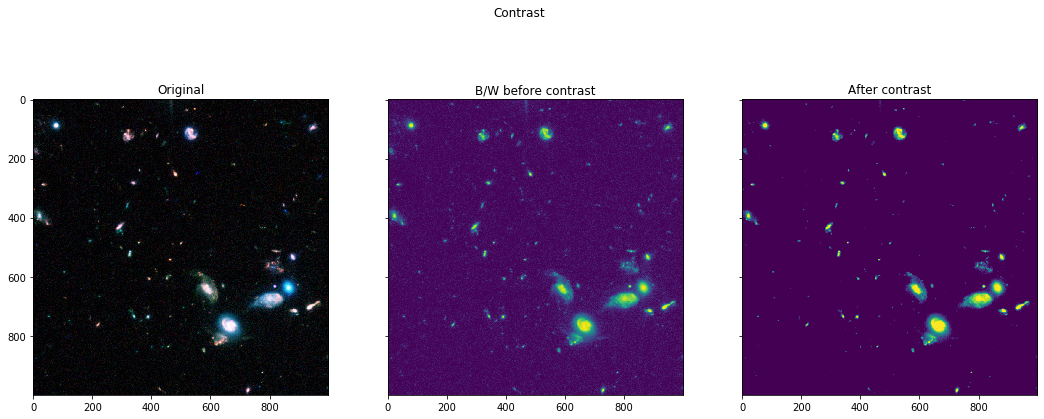

In [117]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,7))

plt.suptitle('Contrast')

ax1.imshow(image[ss_x:se_x, ss_y:se_y])
ax2.imshow(img_gray[ss_x:se_x, ss_y:se_y])
ax3.imshow(img_contrast[ss_x:se_x, ss_y:se_y])

ax1.set_title('Original')
ax2.set_title('B/W before contrast')
ax3.set_title('After contrast')

plt.show()

## Add blur and convert to binary image

In [118]:
# Blur image
img_blur = cv2.medianBlur(img_contrast, 5)

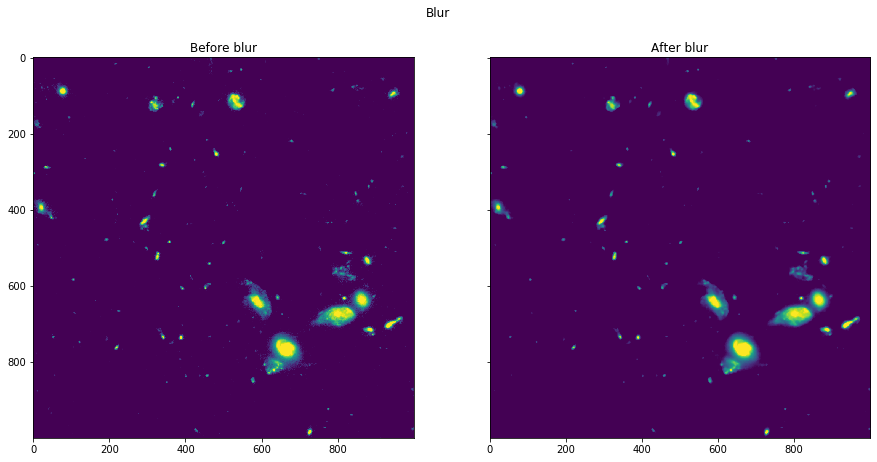

In [119]:
# Show images
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))

plt.suptitle('Blur')

ax1.imshow(img_contrast[ss_x:se_x, ss_y:se_y])
ax2.imshow(img_blur[ss_x:se_x, ss_y:se_y])

ax1.set_title('Before blur')
ax2.set_title('After blur')
plt.show()

## Apply thresholding

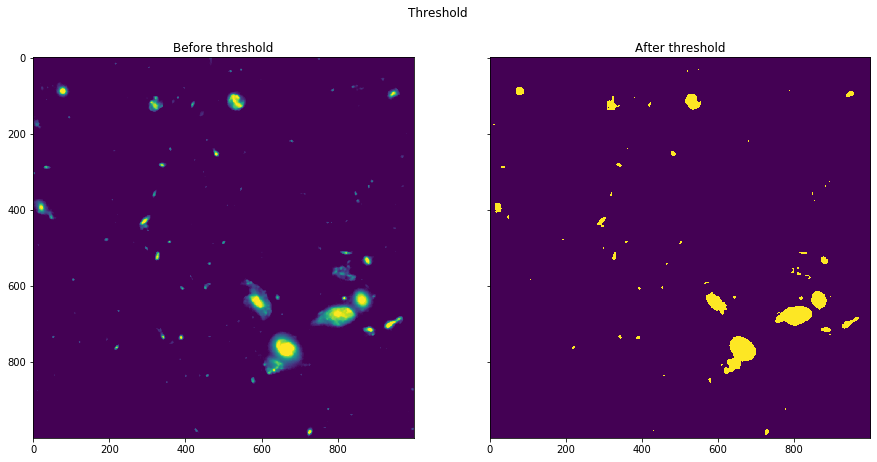

Size: 38440000


In [120]:
ret,img_bin = cv2.threshold(img_blur, 90, 255, cv2.THRESH_BINARY)


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))

plt.suptitle('Threshold')

ax1.imshow(img_blur[ss_x:se_x, ss_y:se_y])
ax2.imshow(img_bin[ss_x:se_x, ss_y:se_y])

ax1.set_title('Before threshold')
ax2.set_title('After threshold')
plt.show()

print("Size:", img_bin.nbytes)

## Create HSV-copy of original image
A HSV copy of the image will be used to calculate average hue, saturation and brightness for the found contours

In [121]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
img_hsv = cv2.medianBlur(img_hsv, 5)

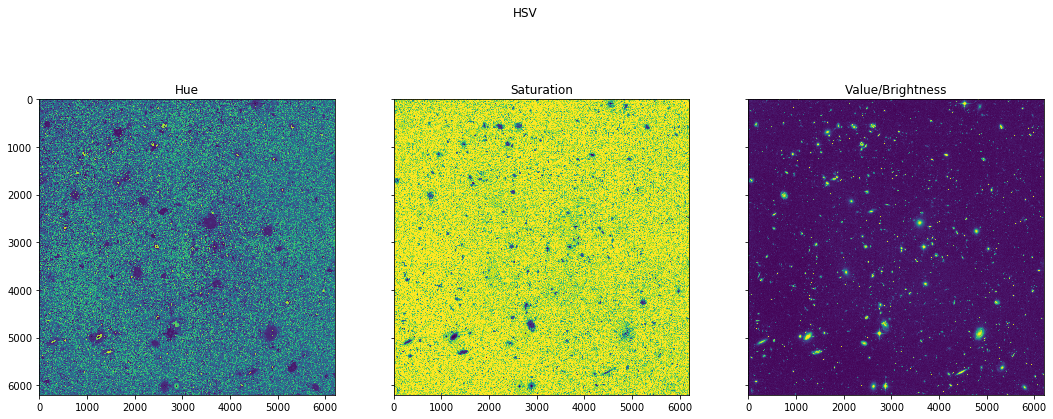

In [122]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,7))

plt.suptitle('HSV')

ax1.imshow(img_hsv[:,:,0])
ax2.imshow(img_hsv[:,:,1])
ax3.imshow(img_hsv[:,:,2])

ax1.set_title('Hue')
ax2.set_title('Saturation')
ax3.set_title('Value/Brightness')


plt.show()

## Find contours

In [123]:
ret_mode = cv2.RETR_TREE
approx_mode = cv2.CHAIN_APPROX_SIMPLE
approx_mode = cv2.CHAIN_APPROX_NONE

contours, _ = cv2.findContours(img_bin, ret_mode, approx_mode)
print("Countours:", len(contours))

Countours: 2182


### Draw contours on original image (a copy of)



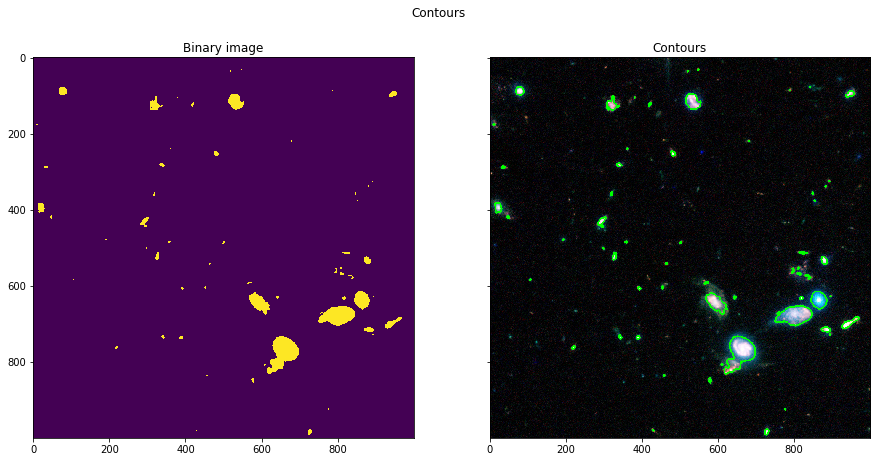

In [124]:
img_cont = image.copy()
cv2.drawContours(img_cont, contours, -1, (0,255,0), 3)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))

plt.suptitle('Contours')

ax1.imshow(img_bin[ss_x:se_x, ss_y:se_y])
ax2.imshow(img_cont[ss_x:se_x, ss_y:se_y])

ax1.set_title('Binary image')
ax2.set_title('Contours')
plt.show()


## Collect data from contours

### Function to crop an image to fit a contour

In [125]:
def crop_contour(contour, image):
    '''Crop contour image'''
    
    # Find bounding circle
    center, radius = cv2.minEnclosingCircle(contour)
    
    rect = cv2.boundingRect(contour)
    
    x1 = rect[0]
    y1 = rect[1]

    x2 = rect[0] + rect[2]
    y2 = rect[1] + rect[3]

    
    roi = image[y1:y2, x1:x2]
    return roi
    

### Function to collect color data from region of interest

In [126]:
def get_color_data(img_hsv):
    h_array = img_hsv[:,:,0].flatten()
    s_array = img_hsv[:,:,1].flatten()
    v_array = img_hsv[:,:,2].flatten()
    
    data = {
        'c_hue': np.average(h_array),
        'c_sat': np.average(s_array),
        'c_val': np.average(v_array)
    }
    return data

### Iterate the contours and collect data

This is the main loop that iterates thorugh the found contours and extract data from them. The data concists of:
* Position (X and Y)
* Width of enclosing ellipse
* Height of enclosing ellipse
* Angle of ellipse
* Colorinformation: average hue, saturation and value

In [127]:
''' Iterate through contours '''

ellipses = []
cropped_img = []

data = []

img_ellipses = image.copy()

for i in range(len(contours)):
    c = contours[i]
    cropped = crop_contour(c, img_hsv)
    cropped_img.append(cropped)

    
    if len(c) > 4:
        e = cv2.fitEllipse(c)
        ellipses.append(e)
        cv2.ellipse(img_ellipses, e, (255, 0, 0), 2)
        pos = e[0]
        size = e[1]
        angle = e[2]
        
        object_data = {
            'pos_x': pos[0],
            'pos_y': pos[1],
            'width': max(1, size[0]),
            'height': max(1, size[1]),
            'ellipse_area': max(1, size[0] * size[1] * np.pi),
            'angle': angle
        }
        
        object_data.update(get_color_data(cropped))
        
        data.append(object_data)
        
    else:
        pass

        
print("Ellipses:", len(ellipses), '- Lost:', len(contours) - len(ellipses))        

Ellipses: 2030 - Lost: 152


### Plot the contours and ellipses

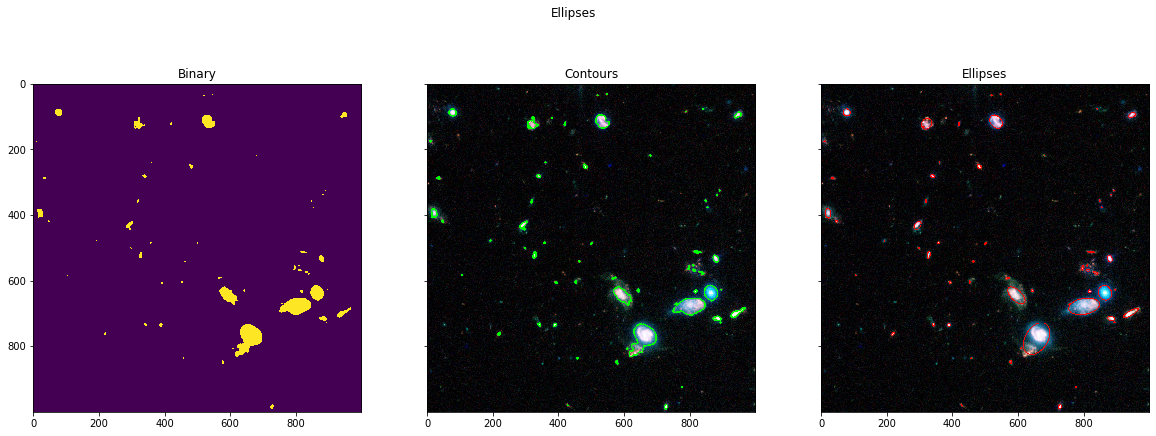

In [128]:
''' Show ellipses '''

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,7))

plt.suptitle('Ellipses')

ax1.imshow(img_bin[ss_x:se_x, ss_y:se_y])
ax2.imshow(img_cont[ss_x:se_x, ss_y:se_y])
ax3.imshow(img_ellipses[ss_x:se_x, ss_y:se_y])

ax1.set_title('Binary')
ax2.set_title('Contours')
ax3.set_title('Ellipses')
plt.show()


## Create DataFrame
Next step is to create a Pandas DataFrame with the collected data.

In [129]:
df = pd.DataFrame(data)
df.index.names = ['id']
df.sort_values('width', ascending=True).head(10)

,angle,c_hue,c_sat,c_val,ellipse_area,height,pos_x,pos_y,width
id,,,,,,,,,
1014,0.0,120.333333,89.666667,133.666667,1.0,1.0,3202.500000,3010.000000,1.0
761,0.0,38.333333,134.333333,123.000000,1.0,1.0,1228.500000,3759.000000,1.0
1320,0.0,36.000000,173.333333,129.000000,1.0,1.0,323.000000,2111.500000,1.0
1306,0.0,111.833333,159.833333,206.166667,1.0,1.0,4689.000000,2136.500000,1.0
797,0.0,72.833333,64.666667,120.500000,1.0,1.0,219.800003,3632.500000,1.0
228,180.0,43.666667,92.500000,109.666667,1.0,1.0,315.500000,5397.799805,1.0
1816,0.0,45.500000,114.166667,114.500000,1.0,1.0,215.000000,681.500000,1.0
1838,0.0,110.833333,101.833333,152.833333,1.0,1.0,5347.200195,617.500000,1.0
829,0.0,104.166667,94.000000,133.500000,1.0,1.0,2574.500000,3561.800049,1.0


### Normalize position and size values

In [130]:
df['pos_x'] = df['pos_x'] / image.shape[1]
df['pos_y'] = df['pos_y'] / image.shape[0]

df['height'] = df['height'] / image.shape[0]
df['width'] = df['width'] / image.shape[1]

df.head()

,angle,c_hue,c_sat,c_val,ellipse_area,height,pos_x,pos_y,width
id,,,,,,,,,
0,100.816788,108.595238,96.119048,211.928571,121.127711,0.001109,0.591914,0.999471,0.000905
1,129.274643,41.183673,143.693878,123.734694,105.074966,0.000994,0.771994,0.998749,0.000876
2,18.020689,115.550000,109.100000,190.100000,48.677202,0.000762,0.161694,0.998387,0.000529
3,90.000000,99.750000,100.250000,147.500000,50.401853,0.000751,0.758548,0.997844,0.000556
4,3.136233,43.595238,80.785714,130.380952,93.253515,0.000941,0.760920,0.997855,0.000821


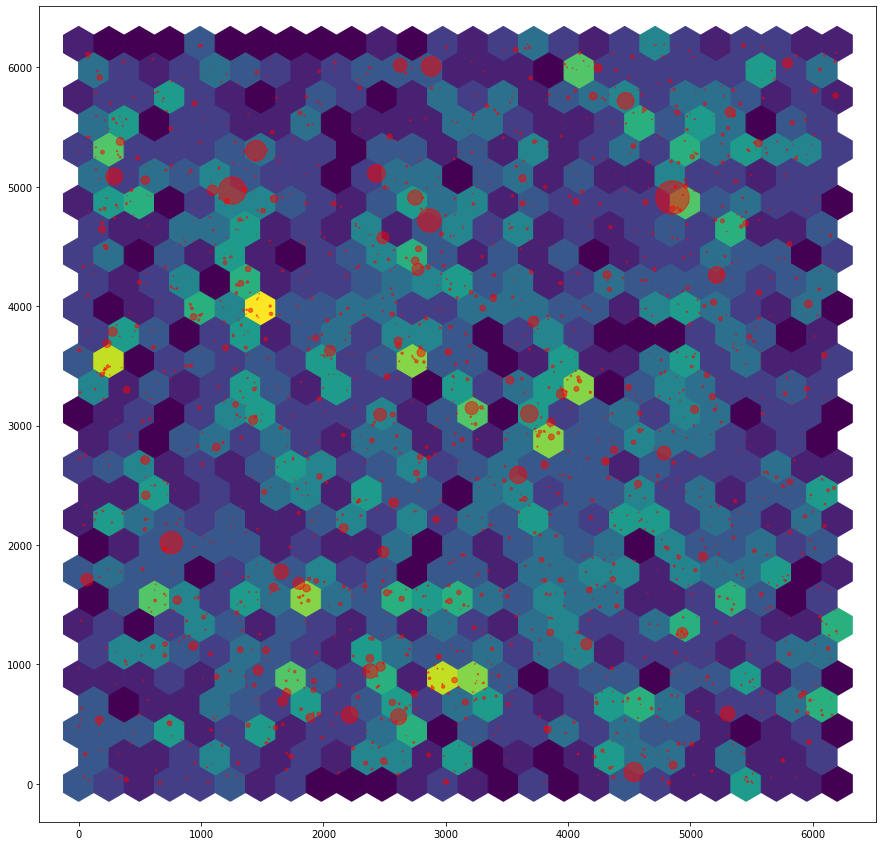

In [131]:
plt.figure(figsize = (15, 15))
plt.hexbin(df['pos_x'] * image.shape[1], df['pos_y'] * image.shape[0], gridsize=25)
#plt.imshow(image, alpha=0.5)
plt.scatter(df['pos_x'] * image.shape[1], 
            df['pos_y'] * image.shape[0], 
            df['ellipse_area'] * 0.01,
            color='red',
            alpha=0.5)
plt.show()

## Draw ellipses from DataFrame

In [132]:
img_width = 800
img_height = 800

img_df = np.zeros((img_width, img_height, 3), dtype=np.uint8)
img_df.shape

(800, 800, 3)

In [133]:
def hsv_to_bgr(hsv):
    hsv_img = np.uint8([[ hsv ]])
    bgr = cv2.cvtColor(hsv_img,cv2.COLOR_HSV2BGR)
    return tuple(map(int, bgr.flatten()))


In [134]:
hsv_to_bgr(tuple([60, 255, 255]))

(0, 255, 0)

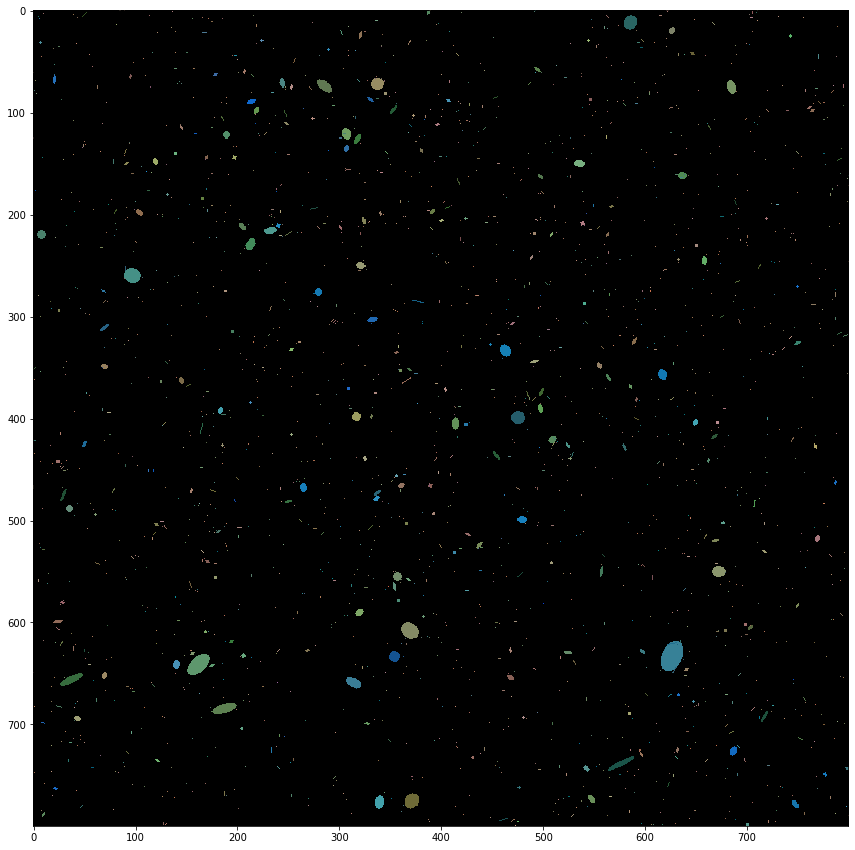

In [135]:
for index, e in df.iterrows():
    x = int(e['pos_x'] * img_width)
    y = int(e['pos_y'] * img_height)
    w = int(e['width'] * img_width * 0.5)
    h = int(e['height'] * img_height * 0.5)
    hsv = (e['c_hue'], e['c_sat'], e['c_val'])
    a = e['angle']
    
    cv2.ellipse(img_df,(x, y),(w, h), a, 0, 360, hsv_to_bgr(hsv), -1)

plt.figure(figsize = (15, 15))    
plt.imshow(img_df)
plt.show()

## Color analysis

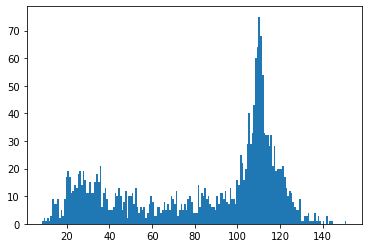

In [136]:
plt.hist(df['c_hue'], bins=180)
plt.show()

In [137]:
# df.to_csv('hubble/data/output.csv')

In [138]:
#files.download('output.csv')